In [1]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
import os
import random
import matplotlib.pyplot as plt
import numpy as np

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

In [2]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Define paths
data_dir = '/kaggle/input/tourism-mobile/new_data'
train_path = os.path.join(data_dir, 'train')
val_path = os.path.join(data_dir, 'validation')
test_path = os.path.join(data_dir, 'test')

In [4]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Define transformations
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
from torchvision.datasets.folder import default_loader
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None, loader=default_loader, is_valid_file=None, ignore_folders=None):
        self.ignore_folders = ignore_folders
        super(CustomImageFolder, self).__init__(root, transform=transform, loader=loader, is_valid_file=is_valid_file)

    def find_classes(self, directory):
        classes = [d.name for d in os.scandir(directory) if d.is_dir() and d.name not in self.ignore_folders]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx
# Load datasets
train_dataset = CustomImageFolder(root=train_path, transform=train_transform,ignore_folders=['Cresent_Mall', 'Emart_Sala', 'UBND_TPHCM'])
val_dataset = CustomImageFolder(root=val_path, transform=val_transform,ignore_folders=['Cresent_Mall', 'Emart_Sala', 'UBND_TPHCM'])
test_dataset = CustomImageFolder(root=test_path, transform=test_transform,ignore_folders=['Cresent_Mall', 'Emart_Sala', 'UBND_TPHCM'])

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [7]:
# Load pre-trained MobileNetV2 model
model = torchvision.models.vgg16(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
model.classifier[1].requires_grad = True
model.classifier[3].requires_grad = True
model.classifier[6] = nn.Linear(model.classifier[6].in_features, len(train_dataset.classes))
model.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:19<00:00, 28.0MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
model.class_to_idx = train_dataset.class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Assuming 'device' is defined earlier as torch.device("cuda:0") if available, else "cpu"

# Define number of epochs
num_epochs = 60

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Learning rate scheduling
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# Early stopping
best_val_loss = np.Inf
patience = 20
early_stopping_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)  # Gradient clipping
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images, val_labels = val_images.to(device), val_labels.to(device)
            val_outputs = model(val_images)
            val_loss = criterion(val_outputs, val_labels)
            val_running_loss += val_loss.item()
            _, val_predicted = val_outputs.max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()
            
    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    # Learning rate scheduling step
    scheduler.step()
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        # Save the model checkpoint
        torch.save(model, '/kaggle/working/best_model.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered!")
            break
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/60], Train Loss: 1.1991, Train Accuracy: 0.6628, Validation Loss: 0.6359, Validation Accuracy: 0.8190
Epoch [2/60], Train Loss: 0.7396, Train Accuracy: 0.7884, Validation Loss: 0.5231, Validation Accuracy: 0.8464
Epoch [3/60], Train Loss: 0.6760, Train Accuracy: 0.8109, Validation Loss: 0.5044, Validation Accuracy: 0.8548
Epoch [4/60], Train Loss: 0.6932, Train Accuracy: 0.7986, Validation Loss: 0.4762, Validation Accuracy: 0.8595
Epoch [5/60], Train Loss: 0.6531, Train Accuracy: 0.8065, Validation Loss: 0.4717, Validation Accuracy: 0.8679
Epoch [6/60], Train Loss: 0.6334, Train Accuracy: 0.8112, Validation Loss: 0.4467, Validation Accuracy: 0.8821
Epoch [7/60], Train Loss: 0.5930, Train Accuracy: 0.8274, Validation Loss: 0.3989, Validation Accuracy: 0.8798
Epoch [8/60], Train Loss: 0.6102, Train Accuracy: 0.8206, Validation Loss: 0.4228, Validation Accuracy: 0.8821
Epoch [9/60], Train Loss: 0.5977, Train Accuracy: 0.8327, Validation Loss: 0.4490, Validation Accuracy: 0.8881
E

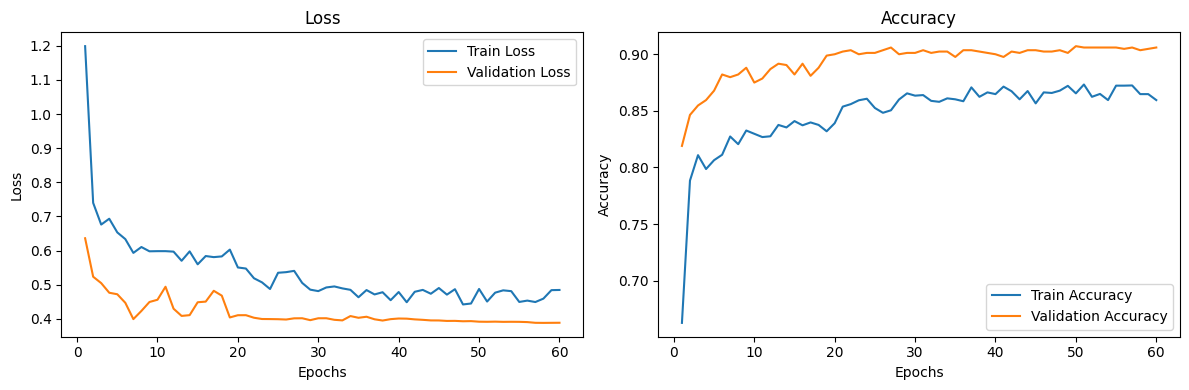

In [11]:
# Plotting training and validation loss and accuracy
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        test_acc = 0
        all_preds = []
        all_labels = []
        
        for data, label in test_loader:
            data, label = data.cuda(), label.cuda()
            
            output = model(data)
            
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(label.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            test_acc += accuracy.item() * data.size(0)
            
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
        
        test_acc = test_acc / len(test_loader.dataset)
        
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        return test_acc, precision, recall, f1

# Load the saved weights
model = torch.load('/kaggle/working/best_model.pth')

# Evaluate the model
test_acc, precision, recall, f1 = evaluate_model(model.cuda(), test_loader, criterion)

print(f'The model has achieved an accuracy of {100 * test_acc:.2f}% on the test dataset')
print(f'Precision: {100 * precision:.2f}%')
print(f'Recall: {100 * recall:.2f}%')
print(f'F1 Score: {100 * f1:.2f}%')

The model has achieved an accuracy of 91.37% on the test dataset
Precision: 91.59%
Recall: 91.37%
F1 Score: 91.38%


Predicted label: My_Son
Confidence score: 0.9997201561927795
True label: My_Son


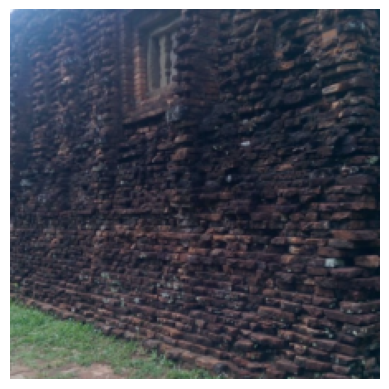

In [13]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Select a random image from the test dataset
random_image_index = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[random_image_index]
image = image.unsqueeze(0).to(device)

# Perform inference
with torch.no_grad():
    output = model(image)
    predicted_probabilities = F.softmax(output, dim=1)
    confidence_score, predicted_label = torch.max(predicted_probabilities, 1)
    predicted_label = predicted_label.item()
    confidence_score = confidence_score.item()

print("Predicted label:", model.idx_to_class[predicted_label])
print("Confidence score:", confidence_score)
print("True label:", test_dataset.classes[true_label])

# Display the image
image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()
image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

plt.imshow(image_np)
plt.axis('off')
plt.show()